Columnas del DataFrame: Index(['usuario_id', 'tipo', 'detalle', 'fecha', 'Transacciones', 'Balance',
       'Tipo_Movimiento', 'Ano', 'Mes', 'Meta de ahorro', 'Column1'],
      dtype='object')
Error cuadrático medio: 3469204036.62


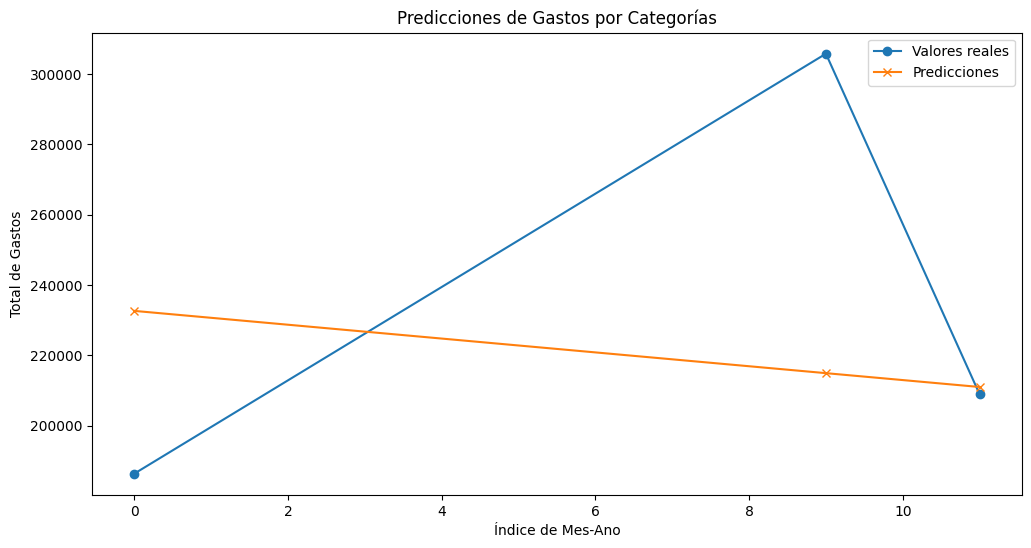

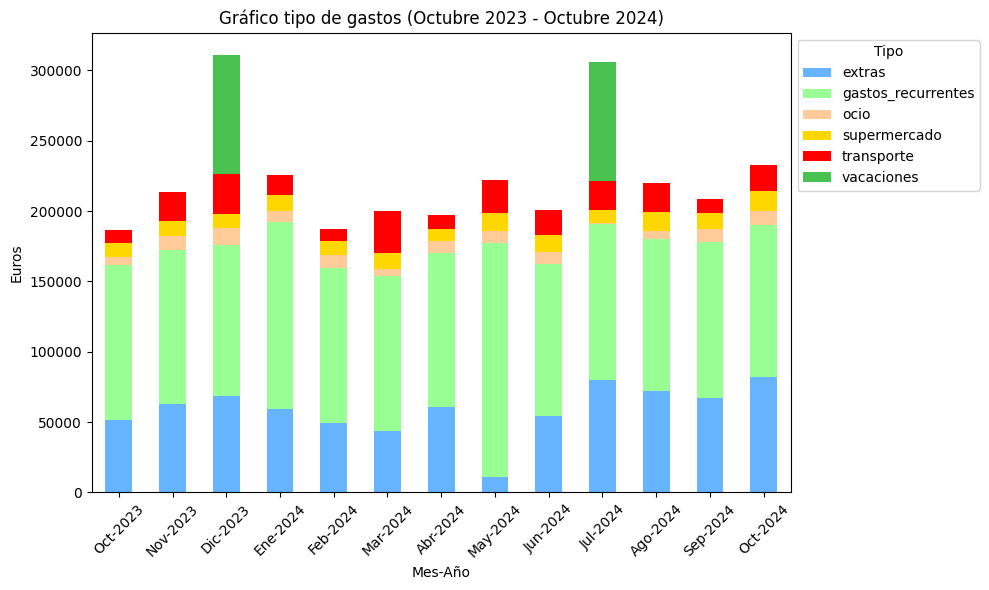

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Leer el archivo CSV
archivo_csv = 'DATOS_FINAL_BBK_vac.csv'
df = pd.read_csv(archivo_csv, sep=',')

# Mostrar las columnas del DataFrame
print("Columnas del DataFrame:", df.columns)

# Definir los años y meses de inicio y fin
anio_inicio = 2023
mes_inicio = 10  # Octubre
anio_fin = 2024
mes_fin = 10     # Octubre

# Cambiar el mes a formato texto con iniciales
meses = {
    1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 
    6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 
    11: 'Nov', 12: 'Dic'
}
df['Mes'] = df['Mes'].map(meses)

# Filtrar el DataFrame por rango de años y meses
df_filtrado = df[
    ((df['Ano'] == anio_inicio) & (df['Mes'].isin(['Oct', 'Nov', 'Dic']))) |
    ((df['Ano'] == anio_fin) & (df['Mes'].isin(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct']))) |
    ((df['Ano'] > anio_inicio) & (df['Ano'] < anio_fin))
]

# Filtrar solo los valores negativos de 'Transacciones'
df_negativos = df_filtrado[df_filtrado['Transacciones'] < 0].copy()

# Crear una columna para los valores absolutos de las transacciones negativas
df_negativos['Transacciones'] = df_negativos['Transacciones'].abs()

# Agrupar los datos por 'Mes', 'Ano' y 'tipo' para obtener la suma de transacciones negativas
df_agrupado = df_negativos.groupby(['Mes', 'Ano', 'tipo'])['Transacciones'].sum().reset_index()

# Crear una columna de nombre de Mes-Año
df_agrupado['Mes-Ano'] = df_agrupado['Mes'] + '-' + df_agrupado['Ano'].astype(str)

# Asegurarse de que el eje X esté ordenado correctamente
orden_meses = [
    'Oct-2023', 'Nov-2023', 'Dic-2023', 
    'Ene-2024', 'Feb-2024', 'Mar-2024', 
    'Abr-2024', 'May-2024', 'Jun-2024', 
    'Jul-2024', 'Ago-2024', 'Sep-2024', 
    'Oct-2024'
]

# Convertir la columna 'Mes-Ano' a categoría ordenada
df_agrupado['Mes-Ano'] = pd.Categorical(df_agrupado['Mes-Ano'], categories=orden_meses, ordered=True)

# Pivotar el DataFrame para facilitar la visualización
df_pivot = df_agrupado.pivot(index='Mes-Ano', columns='tipo', values='Transacciones').fillna(0)

# Modelado predictivo
# Reseteamos el índice para preparar los datos para el modelo
df_pivot.reset_index(inplace=True)

# Separar características y etiquetas
X = np.arange(len(df_pivot)).reshape(-1, 1)  # Convertir el índice a formato matriz
y = df_pivot.drop(columns=['Mes-Ano']).sum(axis=1)  # Total de gastos como objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio: {mse:.2f}')

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valores reales', marker='o')
plt.plot(y_test.index, y_pred, label='Predicciones', marker='x')
plt.title('Predicciones de Gastos por Categorías')
plt.xlabel('Índice de Mes-Ano')
plt.ylabel('Total de Gastos')
plt.legend()
plt.show()

# Crear el gráfico de columnas apiladas
colores = ['#66B3FF', '#99FF95', '#FFCC99', '#FFD700', '#FF0000', '#4ac252']  # El último color es rojo
ax = df_pivot.set_index('Mes-Ano').plot(kind='bar', stacked=True, figsize=(10, 6), color=colores)

# Etiquetas y título
plt.title('Gráfico tipo de gastos (Octubre 2023 - Octubre 2024)')
plt.xlabel('Mes-Año')
plt.ylabel('Euros')
plt.xticks(rotation=45)

# Colocar la leyenda a la izquierda
plt.legend(title='Tipo', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# Mostrar el gráfico
plt.show()
